In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/mammographic.csv", header=None)
df.columns = ["feat_1", "feat_2", "feat_3", "feat_4", "feat_5", "class"]
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,class
0,0.090909,0.628205,0.666667,1.00,0.666667,1.0
1,0.090909,0.512821,1.000000,1.00,0.666667,1.0
2,0.072727,0.128205,0.000000,0.00,0.666667,0.0
3,0.090909,0.500000,0.000000,1.00,0.666667,1.0
4,0.090909,0.743590,0.000000,0.75,0.666667,1.0


In [3]:
X = df.drop(columns=["class"])
y = df.loc[:, "class"]
X.shape, y.shape

((830, 5), (830,))

In [4]:
class LinearGreaterThanZero(nn.Linear):
    def __init__(self, in_features, bias=False, min_w=0.0000001):
        super().__init__(in_features, 1, bias)
        self.is_bias = bias
        self.min_w = min_w
        if bias:
            nn.init.uniform_(self.bias, self.min_w, 1.0)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1, 1.0)

    def w(self):
        with torch.no_grad():
            self.weight.data[self.weight.data < 0] = self.min_w
        return self.weight

    def forward(self, input):
        return F.linear(input, self.w(), self.bias)

In [5]:
class LinearInteraction(nn.Linear):
    def __init__(self, in_features, criterion_layer):
        super().__init__(((in_features - 1) * in_features) // 2, 1, False)
        self.in_features = in_features
        self.criterion_layer = criterion_layer

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0, 0.1)

    def w(self):
        with torch.no_grad():
            w_i = 0
            w = self.criterion_layer.w()
            for i in range(self.in_features):
                for j in range(i + 1, self.in_features):
                    self.weight.data[:, w_i] = torch.max(
                        self.weight.data[:, w_i], -w[:, i]
                    )
                    self.weight.data[:, w_i] = torch.max(
                        self.weight.data[:, w_i], -w[:, j]
                    )
                    w_i += 1
        return self.weight

    def forward(self, input):
        return F.linear(input, self.w(), None)

In [6]:
class ThresholdLayer(nn.Module):
    def __init__(self, threshold=None, requires_grad=True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(
                torch.FloatTensor(1).uniform_(0.1, 0.5), requires_grad=requires_grad
            )
        else:
            self.threshold = nn.Parameter(
                torch.FloatTensor([threshold]), requires_grad=requires_grad
            )

    def forward(self, x):
        return x - self.threshold

In [7]:
class ChoquetConstrained(nn.Module):
    def __init__(self, criteria_nr, **kwargs):
        super().__init__()
        self.criteria_nr = criteria_nr
        self.criteria_layer = LinearGreaterThanZero(criteria_nr)
        self.interaction_layer = LinearInteraction(criteria_nr, self.criteria_layer)
        self.thresholdLayer = ThresholdLayer()

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[:, 0, :]
        x_wi = self.criteria_layer(x[:, : self.criteria_nr])
        x_wij = self.interaction_layer(x[:, self.criteria_nr :])
        weight_sum = self.criteria_layer.w().sum() + self.interaction_layer.w().sum()
        score = (x_wi + x_wij) / (weight_sum)
        return self.thresholdLayer(score)

In [8]:
def mobious_transform(row):
    return list(row) + [
        min(row[i], row[j]) for i in range(len(row)) for j in range(i + 1, len(row))
    ]

In [9]:
df

,feat_1,feat_2,feat_3,feat_4,feat_5,class
0,0.090909,0.628205,0.666667,1.00,0.666667,1.0
1,0.090909,0.512821,1.000000,1.00,0.666667,1.0
2,0.072727,0.128205,0.000000,0.00,0.666667,0.0
3,0.090909,0.500000,0.000000,1.00,0.666667,1.0
4,0.090909,0.743590,0.000000,0.75,0.666667,1.0
...,...,...,...,...,...,...
825,0.072727,0.371795,0.333333,0.00,0.666667,0.0
826,0.072727,0.487179,1.000000,1.00,0.666667,1.0
827,0.072727,0.589744,1.000000,1.00,0.666667,0.0
828,0.090909,0.615385,1.000000,1.00,0.666667,1.0


In [10]:
criteria_nr = 5
print(df.iloc[:, :criteria_nr])
data_input = df.iloc[:, :criteria_nr].apply(
    lambda x: mobious_transform(x), axis=1, result_type="expand"
)
print(data_input)
data_target = df.iloc[:, criteria_nr]

X_train, X_test, y_train, y_test = train_test_split(
    data_input.values, data_target.values, test_size=0.2, random_state=1234
)

       feat_1    feat_2    feat_3  feat_4    feat_5
0    0.090909  0.628205  0.666667    1.00  0.666667
1    0.090909  0.512821  1.000000    1.00  0.666667
2    0.072727  0.128205  0.000000    0.00  0.666667
3    0.090909  0.500000  0.000000    1.00  0.666667
4    0.090909  0.743590  0.000000    0.75  0.666667
..        ...       ...       ...     ...       ...
825  0.072727  0.371795  0.333333    0.00  0.666667
826  0.072727  0.487179  1.000000    1.00  0.666667
827  0.072727  0.589744  1.000000    1.00  0.666667
828  0.090909  0.615385  1.000000    1.00  0.666667
829  0.072727  0.564103  0.666667    0.50  0.666667

[830 rows x 5 columns]
           0         1         2     3         4         5         6   \
0    0.090909  0.628205  0.666667  1.00  0.666667  0.090909  0.090909   
1    0.090909  0.512821  1.000000  1.00  0.666667  0.090909  0.090909   
2    0.072727  0.128205  0.000000  0.00  0.666667  0.072727  0.000000   
3    0.090909  0.500000  0.000000  1.00  0.666667  0.090909 

In [12]:
from helpers import CreateDataLoader, Train

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [13]:
PATH = "choquet.pt"

In [14]:
model = ChoquetConstrained(criteria_nr)

In [15]:
acc, acc_test, auc, auc_test, f1, f1_test = Train(model, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (acc_test * 100.0))
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test:\t%.2f%%" % (f1 * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))


100%|██████████| 200/200 [00:03<00:00, 58.93it/s]

Accuracy train:	81.63%
AUC train: 	74.70%
Accuracy test:	84.63%
AUC test: 	83.20%
F1 test:	79.60%
F1 test: 	73.42%


In [16]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [17]:
weights = model.criteria_layer.w().detach().numpy()[0]
interaction_weights = model.interaction_layer.w().detach().numpy()[0]
s = weights.sum() + interaction_weights.sum()
weights = weights / s
interaction_weights = interaction_weights / s

interactions = np.zeros((criteria_nr, criteria_nr))
weight_id = 0
for i in range(criteria_nr):
    for j in range(i + 1, criteria_nr):
        interactions[i, j] = interactions[j, i] = interaction_weights[weight_id]
        weight_id += 1

In [23]:
print("Criteria weights:")
print([round(weight, 4) for weight in weights])
print()
print("Criteria interactions:")
print(interactions)

Criteria weights:
[0.2804, 0.0364, 0.0, 0.0, 0.1884]

Criteria interactions:
[[ 0.00000000e+00  1.76044866e-01  1.14158869e-01  4.74867970e-02
   1.93540528e-01]
 [ 1.76044866e-01  0.00000000e+00 -3.06755297e-08 -3.06755297e-08
  -3.64388898e-02]
 [ 1.14158869e-01 -3.06755297e-08  0.00000000e+00 -3.06755297e-08
  -3.06755297e-08]
 [ 4.74867970e-02 -3.06755297e-08 -3.06755297e-08  0.00000000e+00
  -3.06755297e-08]
 [ 1.93540528e-01 -3.64388898e-02 -3.06755297e-08 -3.06755297e-08
   0.00000000e+00]]


In [19]:
shapley = weights + interactions.sum(0) / 2
print("Importance of criterina (Shapley value):")
print(shapley)

Importance of criterina (Shapley value):
[0.54602442 0.10624185 0.05707942 0.02374338 0.2669109 ]


In [20]:
with torch.no_grad():
    y_pred = model(torch.Tensor(data_input.values))

avg_predictions_all_features = []

for i in range(5):

    feature_values = torch.Tensor(data_input.iloc[:, i])
    average_predictions = []

    for value in torch.unique(torch.Tensor(feature_values)):
        mask = (feature_values == value)
        average_prediction = torch.mean(y_pred[mask])
        average_predictions.append(average_prediction.item())
    avg_predictions_all_features.append(average_predictions)
print(avg_predictions_all_features)

[[-0.05619024112820625, -0.05524763837456703, -0.01605215109884739, -0.00881020724773407, 0.014809932559728622, 0.023235633969306946, 0.5540633201599121], [-0.022001564502716064, -0.01766888052225113, -0.017487600445747375, -0.012913957238197327, -0.010206158272922039, -0.013879090547561646, -0.03436494991183281, -0.005047142505645752, -0.009198352694511414, -0.005335179157555103, -0.0018657029140740633, -0.009198352694511414, -0.009198352694511414, -0.012476478703320026, -0.004471547901630402, -0.0004459726042114198, -0.007586606778204441, -0.017983708530664444, -0.0068081943318247795, -0.013683848083019257, -0.00692635215818882, -0.012801683507859707, -0.012099344283342361, -0.005526340566575527, -0.019282635301351547, -0.005337539594620466, -0.01266720611602068, -0.007470245473086834, 0.0062066661193966866, -0.011805838905274868, -0.005540076643228531, -0.007852163165807724, 0.00022667559096589684, 0.0016159178921952844, 0.00778504554182291, 0.00039261783240363, 0.004343947861343622

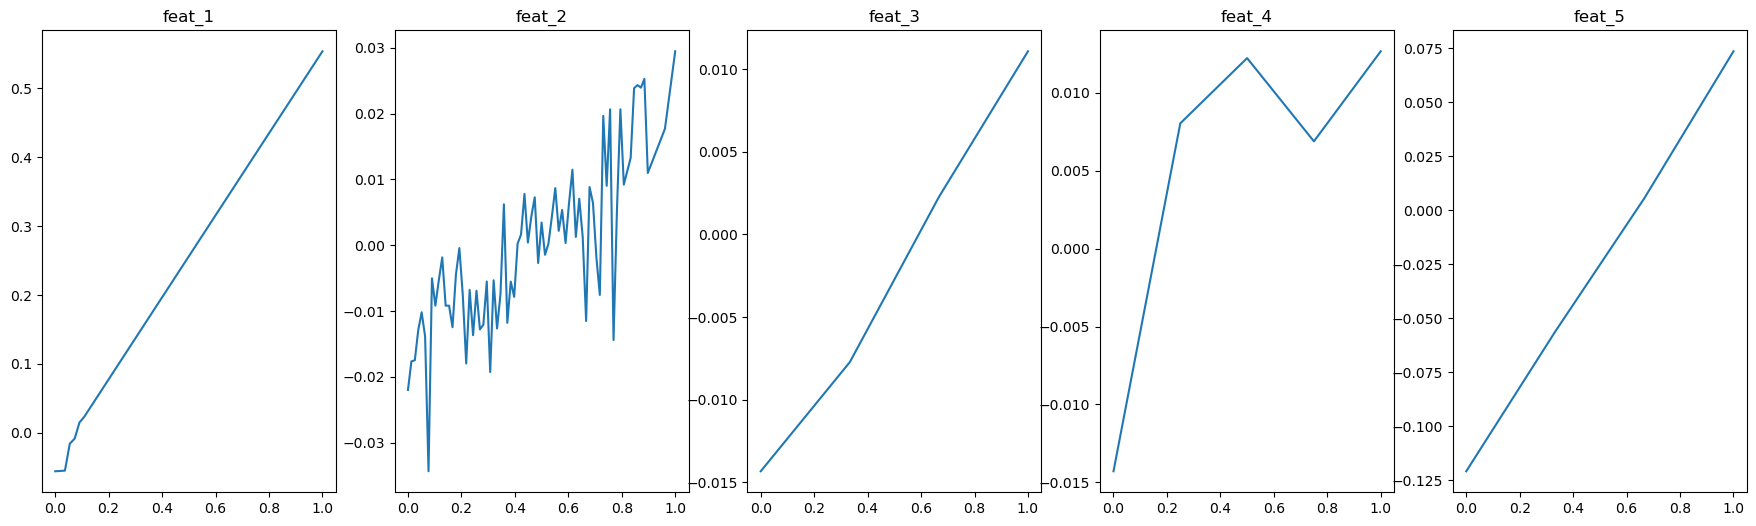

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(22, 6))

for i in range(5):
    axes[i].plot(torch.unique(torch.Tensor(data_input.iloc[:, i])), avg_predictions_all_features[i])
    axes[i].set_title(f'feat_{i+1}')